In [2]:
#import
import os
import sys

import tqdm
import math
import torch
import logging

import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import lightning.pytorch as pl
import matplotlib.pyplot as plt

from scipy import spatial
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

In [3]:
#model
hyperparams_dict = {
        'energy': 5.754,
        'scale_data': False,
        'augment': False,
        'add_abc': False,
        'abc_loss_factor': 1,
        'augment_factor': 20,
        'test_size': 0.001,
        'batch_size': 256,
        'net_architecture': [9,60,80,100,120,140,240,340,440,640,2000,1040,640,340,240,140,100,80,60,20,1],
        'activation_function': nn.ReLU(),
        'loss_func': 'RMSELoss()',
        'optim_func': torch.optim.Adam,
        'max_epochs': 2000,
        'es_min_delta': 0.00001,
        'es_patience': 50,
        'lr': 0.001,
        'lr_factor':0.5,
        'lr_patience': 5,
        'lr_cooldown': 20,
    }

if True:
    class RMSELoss(torch.nn.Module):
        def __init__(self, add_abc=False):
            super(RMSELoss,self).__init__()
            self.add_abc = add_abc

        @staticmethod
        def func_cos(x, a, b, c):
            return a + b*torch.cos(2*x) + c*torch.cos(x)

        def forward(self, x, y_hat, y, w, A, B, C):
            if self.add_abc:
                phi = x[:, 4]
                criterion = torch.sqrt(torch.mean(w*(y_hat - y)**2)/torch.sum(w)) + \
                            torch.mul(hyperparams_dict.get('abc_loss_factor'), torch.mean(torch.abs(w*y - self.func_cos(phi,A,B,C)))/torch.sum(w))
            else:
                criterion = torch.sqrt(torch.mean(w * (y_hat - y) ** 2) / torch.sum(w))
            return criterion

    global_losss_function = RMSELoss()

    #params
    project_name = "MSU_interpol_unified_notebooks"

    logger_path = './wandb_local_logs'
    data_path = './data/clasdb_pi_plus_n.txt'


    logger_full_path = os.path.join(logger_path, project_name, 'spring-feather-42')

    os.makedirs(logger_full_path, exist_ok=True)
    logging.basicConfig(encoding='utf-8',
                        level=logging.DEBUG,
                        format='%(asctime)s : %(levelname)s : %(message)s',
                        handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                                  logging.StreamHandler(sys.stdout)],
                        force=True)

        # define dataset and net
    class InterpolDataSet(Dataset):
        def __init__(self, features, labels, weights, A, B, C):
            self.features = features
            self.labels = labels
            self.weights = weights
            self.A = A
            self.B = B
            self.C = C
            self.len = len(labels)
    
        def __getitem__(self, index):
            feature = self.features[index]
            label = self.labels[index]
            weights = self.weights[index]
            A = self.A[index]
            B = self.B[index]
            C = self.C[index]
            return feature, label, weights, A, B, C
    
        def __len__(self):
            return self.len
    
    
    class InterpolDataModule(pl.LightningDataModule):
        def __init__(self, hyperparams):
            super().__init__()
            self.df = None
            self.hyperparams = hyperparams
            self.train_dataset = None
            self.val_dataset = None
    
        def augment(self, new_augm):
            augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam / 30),
                              'W': np.random.normal(loc=new_augm.W, scale=new_augm.W / 30),
                              'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2 / 30),
                              'cos_theta': np.clip(
                                  np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta / 30)), -1, 1),
                              'phi': np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi / 30), 0, 2 * np.pi),
                              'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error / 3),
                              'error': new_augm.error,
                              'weight': new_augm.weight,
                              })
            if self.hyperparams.get('add_abc'):
                augm['A'] = new_augm.A
                augm['B'] = new_augm.B
                augm['C'] = new_augm.C
            else:
                pass
            return augm
    
        @staticmethod
        def func_cos(x, a, b, c):
            return a + b * np.cos(2 * x) + c * np.cos(x)
    
        def get_abc(self, df, E_beam, Q2, W, cos_theta):
            df_example_set = df[(df.Ebeam == E_beam) &
                                (df.W == W) &
                                (df.Q2 == Q2) &
                                (df.cos_theta == cos_theta)].sort_values('phi')
            # input data
            xdata = df_example_set.phi
            ydata = df_example_set.dsigma_dOmega
            ydata_error = df_example_set.error
            # fitting the data
            popt, pcov = curve_fit(self.func_cos, xdata, ydata, sigma=ydata_error, absolute_sigma=True)
            a, b, c = popt[0], popt[1], popt[2]
    
            return a, b, c
    
        def setup(self, stage):
            # data reading and preprocessing
            df = pd.read_csv(data_path, delimiter='\t', header=None)
            df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
            df.loc[8314:65671, 'Ebeam'] = 5.754  # peculiarity of this dataset.
            df = df[~((df.Ebeam == 5.754) & (~df.Q2.isin([1.715, 2.050, 2.445, 2.915, 3.480, 4.155])))] # peculiarity of this dataset #2
            df['phi'] = df.phi.apply(lambda x: math.radians(x))
            df['weight'] = df['error'].apply(lambda x: x and 1 / x or 100)  # x and 1 / x or 100  is just a reversed error but with validation 1/0 error in this case it will return 100
            df = df.drop('id', axis=1)
            df = df.drop_duplicates(subset=['Ebeam', 'W', 'Q2', 'cos_theta', 'phi'])
            df['cos_phi'] = df['phi'].apply(lambda x: np.cos(x))
            df['sin_phi'] = df['phi'].apply(lambda x: np.sin(x))
            df['theta'] = np.arccos(df['cos_theta'])
            df['sin_theta'] = np.sin(df.theta)
    
            df = df[df.Ebeam == hyperparams_dict.get('energy')]
    
            # #train test split
            feature_columns = ['Ebeam', 'W', 'Q2', 'theta', 'cos_theta', 'sin_theta', 'phi', 'cos_phi', 'sin_phi']
    
            df['A'] = None
            df['B'] = None
            df['C'] = None
            feature_columns_with_additional = ['Ebeam', 'W', 'Q2', 'theta', 'cos_theta', 'sin_theta', 'phi', 'cos_phi', 'sin_phi', 'weight', 'A', 'B', 'C']
    
            if self.hyperparams.get('add_abc'):
                for Ebeam in df.Ebeam.unique():
                    for Q2 in tqdm.tqdm(df[df.Ebeam == Ebeam].Q2.unique(), desc='ABC Q cycle'):
                        for W in df[(df.Ebeam == Ebeam) & (df.Q2 == Q2)].W.unique():
                            for cos_theta in df[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W)].cos_theta.unique():
                                try:
                                    if df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                            df.cos_theta == cos_theta), 'A'].iloc[0] is None:
                                        A, B, C = self.get_abc(df, Ebeam, Q2, W, cos_theta)
                                        df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                                df.cos_theta == cos_theta), 'A'] = A
                                        df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                                df.cos_theta == cos_theta), 'B'] = B
                                        df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                                df.cos_theta == cos_theta), 'C'] = C
                                    else:
                                        pass
                                except Exception as e:
                                    df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                            df.cos_theta == cos_theta), 'A'] = 0
                                    df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                            df.cos_theta == cos_theta), 'B'] = 0
                                    df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                            df.cos_theta == cos_theta), 'C'] = 0
            else:
                pass
    
            feature_data = df[feature_columns_with_additional]
            label_data = df['dsigma_dOmega']
    
            if self.hyperparams.get('scale_data'):
                scaler_feature = StandardScaler()
                scaler_target = StandardScaler()
                feature_data = scaler_feature.fit_transform(feature_data)
                label_data = scaler_target.fit_transform(label_data.values.reshape(-1, 1))
            else:
                pass
    
            if self.hyperparams.get('augment'):
                aug_series_list = []
                for i in tqdm.tqdm(df.itertuples()):
                    for _ in range(self.hyperparams.get('augment_factor')):
                        aug_series_list.append(self.augment(i))
    
                aug_df = pd.DataFrame(aug_series_list)
                df = pd.concat([df, aug_df])
            else:
                pass
    
            self.df = df
    
            train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                      label_data,
                                                                                                      test_size=self.hyperparams.get(
                                                                                                          'test_size'),
                                                                                                      random_state=1438)
    
            self.train_dataset = InterpolDataSet(
                torch.tensor(train_feature_data[feature_columns].values, dtype=torch.float32),
                torch.tensor(train_label_data.values, dtype=torch.float32),
                torch.tensor(train_feature_data['weight'].values, dtype=torch.float32),
                torch.tensor(train_feature_data['A'].astype(float).values, dtype=torch.float32),
                torch.tensor(train_feature_data['B'].astype(float).values, dtype=torch.float32),
                torch.tensor(train_feature_data['C'].astype(float).values, dtype=torch.float32))
    
            self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data[feature_columns].values, dtype=torch.float32),
                                               torch.tensor(val_label_data.values, dtype=torch.float32),
                                               torch.tensor(val_feature_data['weight'].values, dtype=torch.float32),
                                               torch.tensor(train_feature_data['A'].astype(float).values,
                                                            dtype=torch.float32),
                                               torch.tensor(train_feature_data['B'].astype(float).values,
                                                            dtype=torch.float32),
                                               torch.tensor(train_feature_data['C'].astype(float).values,
                                                            dtype=torch.float32))
    
        def train_dataloader(self):
            return DataLoader(dataset=self.train_dataset, batch_size=self.hyperparams.get('batch_size'), shuffle=True,
                              num_workers=0)
    
        def val_dataloader(self):
            return DataLoader(dataset=self.val_dataset, batch_size=self.hyperparams.get('batch_size'), shuffle=True,
                              num_workers=0)
    
    
    class PrintCallbacks(Callback):
        def on_train_start(self, trainer, pl_module):
            logging.info("Training is starting")
    
        def on_train_end(self, trainer, pl_module):
            logging.info("Training is ending")
    
        def on_train_epoch_end(self, trainer, pl_module):
            epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
            logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
            pl_module.training_step_outputs.clear()
    
        def on_validation_epoch_end(self, trainer, pl_module):
            epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
            logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
            pl_module.validation_step_outputs.clear()
    
    
    class InterpolRegressor(pl.LightningModule):
        def __init__(self, hyperparams):
            super(InterpolRegressor, self).__init__()
    
            self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0, 0, 0, 0
            self.hyperparams = hyperparams
            self.save_hyperparameters(self.hyperparams)
    
            self.mae = MeanAbsoluteError()
            self.loss_func = global_losss_function
    
            self.optim = self.hyperparams.get('optim_func')
    
            self.net_architecture = self.hyperparams.get('net_architecture')
            self.activation_function = self.hyperparams.get('activation_function')
    
            self.training_step_outputs = []
            self.validation_step_outputs = []
    
            self.net = nn.Sequential()
            for i in range(1, len(self.net_architecture)):
                self.net.append(nn.Linear(self.net_architecture[i - 1], self.net_architecture[i]))
                if i != len(self.net_architecture) - 1:
                    self.net.append(self.activation_function)
                else:
                    pass
    
        def forward(self, x):
            return self.net(x)
    
        def training_step(self, batch, batch_idx):
            x, y, w, A, B, C = batch
            y_hat = self.forward(x)
    
            loss = self.loss_func
            self.train_loss = loss.forward(x=x, y_hat=y_hat.reshape(-1), y=y, w=w, A=A, B=B, C=C)
            self.train_mae = self.mae(y_hat.reshape(-1), y)
    
            self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
            self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
    
            self.training_step_outputs.append(self.train_loss)
            return self.train_loss
    
        def validation_step(self, batch, batch_idx):
            x, y, w, A, B, C = batch
            y_hat = self.forward(x)
    
            loss = self.loss_func
            self.val_loss = loss.forward(x=x, y_hat=y_hat.reshape(-1), y=y, w=w, A=A, B=B, C=C)
            self.val_mae = self.mae(y_hat.reshape(-1), y)
    
            self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
            self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
    
            self.validation_step_outputs.append(self.val_loss)
            return self.val_loss
    
        def on_validation_epoch_end(self):
            sch = self.lr_schedulers()
            if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch != 0:
                sch.step(self.trainer.callback_metrics["val_loss"])
    
        def configure_callbacks(self):
            early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                                min_delta=self.hyperparams.get('es_min_delta'),
                                                patience=self.hyperparams.get('es_patience'),
                                                verbose=True)
    
            checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                                  monitor="val_loss",
                                                  mode="min",
                                                  dirpath=f"{logger_full_path}/checkpoints",
                                                  filename="{exp_name}{val_loss:.5f}-{epoch:02d}")
    
            lr_monitor = LearningRateMonitor(logging_interval='epoch')
    
            print_callback = PrintCallbacks()
    
            return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]
    
        def configure_optimizers(self):
            optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
            lr_optim = ReduceLROnPlateau(optimizer=optimizer,
                                         mode='min',
                                         factor=self.hyperparams.get('lr_factor'),
                                         patience=self.hyperparams.get('lr_patience'),
                                         cooldown=self.hyperparams.get('lr_cooldown'),
                                         threshold=0.01,
                                         verbose=True)
            return {"optimizer": optimizer,
                    "lr_scheduler": {
                        "scheduler": lr_optim,
                        "interval": "epoch",
                        "monitor": "val_loss",
                        "frequency": 2,
                        "name": 'lr_scheduler_monitoring'}
                    }

    data = InterpolDataModule(hyperparams_dict)
    data.setup('test')
    df = data.df
    df_all = df[['Ebeam', 'W', 'Q2', 'theta', 'cos_theta', 'sin_theta', 'phi', 'cos_phi', 'sin_phi']]
    df_target = df[['dsigma_dOmega']]

In [4]:
df = df.drop(['A', 'B', 'C'], axis=1)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,weight,cos_phi,sin_phi,theta,sin_theta
8314,5.754,1.11,1.715,-0.1,0.130900,0.24835,0.081150,12.322859,0.991445,0.130526,1.670964,0.994987
8315,5.754,1.11,1.715,-0.1,0.392699,0.31508,0.089290,11.199462,0.923880,0.382683,1.670964,0.994987
8316,5.754,1.11,1.715,-0.1,0.654498,0.33037,0.097020,10.307153,0.793353,0.608761,1.670964,0.994987
8317,5.754,1.11,1.715,-0.1,0.916298,0.22582,0.059600,16.778523,0.608761,0.793353,1.670964,0.994987
8318,5.754,1.11,1.715,0.1,0.130900,0.31506,0.095400,10.482180,0.991445,0.130526,1.470629,0.994987
...,...,...,...,...,...,...,...,...,...,...,...,...
65666,5.754,1.15,4.155,0.9,3.403392,0.24095,0.071110,14.062691,-0.965926,-0.258819,0.451027,0.435890
65667,5.754,1.15,4.155,0.9,3.926991,0.19967,0.078718,12.703601,-0.707107,-0.707107,0.451027,0.435890
65668,5.754,1.15,4.155,0.9,4.450590,0.10080,0.037233,26.857784,-0.258819,-0.965926,0.451027,0.435890
65669,5.754,1.15,4.155,0.9,4.974188,0.13921,0.065774,15.203686,0.258819,-0.965926,0.451027,0.435890


In [5]:
model = InterpolRegressor.load_from_checkpoint(f'/Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/misty-silence-1/checkpoints/exp_name=0val_loss=0.08200-epoch=62.ckpt', hyperparams=hyperparams_dict)
model.eval()
type(model)

2025-02-09 22:31:12,536 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/misty-silence-1/checkpoints/exp_name=0val_loss=0.08200-epoch=62.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


__main__.InterpolRegressor

In [ ]:
df_grid = df

In [ ]:
# make grid preds
if True:
    df_grid_parts = np.array_split(df, 
                                   100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        df_grid_part_pred_for_pred = df_grid_part[['Ebeam', 'W', 'Q2', 'theta', 'cos_theta', 'sin_theta', 'phi', 'cos_phi', 'sin_phi']]
        dsigma_dOmega_predicted = model.to('cpu').forward(torch.tensor(df_grid_part_pred_for_pred.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted_stage_1'] = dsigma_dOmega_predicted
        df_grid_part['dsigma_dOmega_predicted_stage_1'] = abs(df_grid_part.dsigma_dOmega_predicted_stage_1)
        df_grid_parts_preds.append(df_grid_part)

    df_grid = pd.concat(df_grid_parts_preds)

In [ ]:
df_grid['dsigma_dOmega_replica_stage_2'] = df_grid.apply(lambda x: [np.random.normal(x.dsigma_dOmega_predicted_stage_1, x.error) for _ in range(100)], axis=1)

In [ ]:
df_grid[[f'dsigma_dOmega_replica_{i}' for i in range(100)]] = pd.DataFrame(df_grid.dsigma_dOmega_replica_stage_2.tolist(), index= df_grid.index)

In [ ]:
df_grid.describe()[[f'dsigma_dOmega_replica_{i}' for i in range(100)]].loc['std'].hist()

In [ ]:
df_grid.iloc[1][[f'dsigma_dOmega_replica_{i}' for i in range(100)]].std()

In [ ]:
df_grid = df_grid.drop(['dsigma_dOmega_replica_stage_2'], axis=1)

In [6]:
# df_grid.to_csv('./data/df_replicas_new.csv', index=False)
# df_grid = pd.read_csv('./data/replicas/df_replicas_final.csv')
df = pd.read_csv('./data/replicas_new/df_replicas_final.csv')

In [ ]:
sample_id = 142
print(f'Row number: {sample_id}')
print(f'Original value of dsigma_dOmega_predicted_stage_1: {df_grid.iloc[sample_id]['dsigma_dOmega_predicted_stage_1']}')
print(f'Original value of data error: {df_grid.iloc[sample_id]['error']}')

print(f'Samples mean in the row: {df_grid.iloc[sample_id][[f'dsigma_dOmega_replica_{i}' for i in range(100)]].mean()}')
print(f'Samples std in the row:{df_grid.iloc[sample_id][[f'dsigma_dOmega_replica_{i}' for i in range(100)]].std()}')

In [ ]:
df_grid.dsigma_dOmega.hist(label=f'dsigma_dOmega_exp. '
                                 f'mean:{np.round(df_grid.dsigma_dOmega.mean(), 3)}, '
                                 f'std:{np.round(df_grid.dsigma_dOmega.std(), 3)}')

df_grid.dsigma_dOmega_predicted_stage_1.hist(label=f'dsigma_dOmega_predicted_stage_1. '
                                                   f'mean: {str(np.round(df_grid.dsigma_dOmega_predicted_stage_1.mean(), 10))[:5]}, '
                                                   f'std: {str(np.round(df_grid.dsigma_dOmega_predicted_stage_1.std(), 10))[:5]}', alpha=0.7)


plt.xlabel('dsigma_dOmega')
plt.ylabel('count')
plt.title('dsigma_dOmega_exp and dsigma_dOmega_predicted_stage_1 distribution')
plt.legend()

In [ ]:
df_grid.describe()[[f'dsigma_dOmega_replica_{i}' for i in range(100)]].loc['std'].hist()
plt.title('replicas std distribution')

In [ ]:
df_grid.describe()[[f'dsigma_dOmega_replica_{i}' for i in range(100)]].loc['mean'].hist()
plt.title('replicas mean distribution')

## Make one grid_pred

In [ ]:
#model
hyperparams_dict = {
        'energy': 5.754,
        'scale_data': False,
        'augment': False,
        'add_abc': False,
        'abc_loss_factor': 1,
        'augment_factor': 20,
        'test_size': 0.001,
        'batch_size': 256,
        'net_architecture': [9,60,80,100,120,140,240,340,440,640,2000,1040,640,340,240,140,100,80,60,20,1],
        'activation_function': nn.ReLU(),
        'loss_func': 'RMSELoss()',
        'optim_func': torch.optim.Adam,
        'max_epochs': 2000,
        'es_min_delta': 0.00001,
        'es_patience': 50,
        'lr': 0.001,
        'lr_factor':0.5,
        'lr_patience': 5,
        'lr_cooldown': 20,
    }

if True:
    class RMSELoss(torch.nn.Module):
        def __init__(self, add_abc=False):
            super(RMSELoss,self).__init__()
            self.add_abc = add_abc

        @staticmethod
        def func_cos(x, a, b, c):
            return a + b*torch.cos(2*x) + c*torch.cos(x)

        def forward(self, x, y_hat, y, w, A, B, C):
            if self.add_abc:
                phi = x[:, 4]
                criterion = torch.sqrt(torch.mean(w*(y_hat - y)**2)/torch.sum(w)) + \
                            torch.mul(hyperparams_dict.get('abc_loss_factor'), torch.mean(torch.abs(w*y - self.func_cos(phi,A,B,C)))/torch.sum(w))
            else:
                criterion = torch.sqrt(torch.mean(w * (y_hat - y) ** 2) / torch.sum(w))
            return criterion

    global_losss_function = RMSELoss()

    #params
    project_name = "MSU_interpol_unified_notebooks"

    logger_path = './wandb_local_logs'
    data_path = './data/clasdb_pi_plus_n.txt'


    logger_full_path = os.path.join(logger_path, project_name, 'spring-feather-42')

    os.makedirs(logger_full_path, exist_ok=True)
    logging.basicConfig(encoding='utf-8',
                        level=logging.DEBUG,
                        format='%(asctime)s : %(levelname)s : %(message)s',
                        handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                                  logging.StreamHandler(sys.stdout)],
                        force=True)

        # define dataset and net
    class InterpolDataSet(Dataset):
        def __init__(self, features, labels, weights, A, B, C):
            self.features = features
            self.labels = labels
            self.weights = weights
            self.A = A
            self.B = B
            self.C = C
            self.len = len(labels)
    
        def __getitem__(self, index):
            feature = self.features[index]
            label = self.labels[index]
            weights = self.weights[index]
            A = self.A[index]
            B = self.B[index]
            C = self.C[index]
            return feature, label, weights, A, B, C
    
        def __len__(self):
            return self.len
    
    
    class InterpolDataModule(pl.LightningDataModule):
        def __init__(self, hyperparams):
            super().__init__()
            self.df = None
            self.hyperparams = hyperparams
            self.train_dataset = None
            self.val_dataset = None
    
        def augment(self, new_augm):
            augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam / 30),
                              'W': np.random.normal(loc=new_augm.W, scale=new_augm.W / 30),
                              'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2 / 30),
                              'cos_theta': np.clip(
                                  np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta / 30)), -1, 1),
                              'phi': np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi / 30), 0, 2 * np.pi),
                              'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error / 3),
                              'error': new_augm.error,
                              'weight': new_augm.weight,
                              })
            if self.hyperparams.get('add_abc'):
                augm['A'] = new_augm.A
                augm['B'] = new_augm.B
                augm['C'] = new_augm.C
            else:
                pass
            return augm
    
        @staticmethod
        def func_cos(x, a, b, c):
            return a + b * np.cos(2 * x) + c * np.cos(x)
    
        def get_abc(self, df, E_beam, Q2, W, cos_theta):
            df_example_set = df[(df.Ebeam == E_beam) &
                                (df.W == W) &
                                (df.Q2 == Q2) &
                                (df.cos_theta == cos_theta)].sort_values('phi')
            # input data
            xdata = df_example_set.phi
            ydata = df_example_set.dsigma_dOmega
            ydata_error = df_example_set.error
            # fitting the data
            popt, pcov = curve_fit(self.func_cos, xdata, ydata, sigma=ydata_error, absolute_sigma=True)
            a, b, c = popt[0], popt[1], popt[2]
    
            return a, b, c
    
        def setup(self, stage):
            # data reading and preprocessing
            df = pd.read_csv(data_path, delimiter='\t', header=None)
            df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
            df.loc[8314:65671, 'Ebeam'] = 5.754  # peculiarity of this dataset.
            df = df[~((df.Ebeam == 5.754) & (~df.Q2.isin([1.715, 2.050, 2.445, 2.915, 3.480, 4.155])))] # peculiarity of this dataset #2
            df['phi'] = df.phi.apply(lambda x: math.radians(x))
            df['weight'] = df['error'].apply(lambda x: x and 1 / x or 100)  # x and 1 / x or 100  is just a reversed error but with validation 1/0 error in this case it will return 100
            df = df.drop('id', axis=1)
            df = df.drop_duplicates(subset=['Ebeam', 'W', 'Q2', 'cos_theta', 'phi'])
            df['cos_phi'] = df['phi'].apply(lambda x: np.cos(x))
            df['sin_phi'] = df['phi'].apply(lambda x: np.sin(x))
            df['theta'] = np.arccos(df['cos_theta'])
            df['sin_theta'] = np.sin(df.theta)
    
            df = df[df.Ebeam == hyperparams_dict.get('energy')]
    
            # #train test split
            feature_columns = ['Ebeam', 'W', 'Q2', 'theta', 'cos_theta', 'sin_theta', 'phi', 'cos_phi', 'sin_phi']
    
            df['A'] = None
            df['B'] = None
            df['C'] = None
            feature_columns_with_additional = ['Ebeam', 'W', 'Q2', 'theta', 'cos_theta', 'sin_theta', 'phi', 'cos_phi', 'sin_phi', 'weight', 'A', 'B', 'C']
    
            if self.hyperparams.get('add_abc'):
                for Ebeam in df.Ebeam.unique():
                    for Q2 in tqdm.tqdm(df[df.Ebeam == Ebeam].Q2.unique(), desc='ABC Q cycle'):
                        for W in df[(df.Ebeam == Ebeam) & (df.Q2 == Q2)].W.unique():
                            for cos_theta in df[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W)].cos_theta.unique():
                                try:
                                    if df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                            df.cos_theta == cos_theta), 'A'].iloc[0] is None:
                                        A, B, C = self.get_abc(df, Ebeam, Q2, W, cos_theta)
                                        df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                                df.cos_theta == cos_theta), 'A'] = A
                                        df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                                df.cos_theta == cos_theta), 'B'] = B
                                        df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                                df.cos_theta == cos_theta), 'C'] = C
                                    else:
                                        pass
                                except Exception as e:
                                    df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                            df.cos_theta == cos_theta), 'A'] = 0
                                    df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                            df.cos_theta == cos_theta), 'B'] = 0
                                    df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                            df.cos_theta == cos_theta), 'C'] = 0
            else:
                pass
    
            feature_data = df[feature_columns_with_additional]
            label_data = df['dsigma_dOmega']
    
            if self.hyperparams.get('scale_data'):
                scaler_feature = StandardScaler()
                scaler_target = StandardScaler()
                feature_data = scaler_feature.fit_transform(feature_data)
                label_data = scaler_target.fit_transform(label_data.values.reshape(-1, 1))
            else:
                pass
    
            if self.hyperparams.get('augment'):
                aug_series_list = []
                for i in tqdm.tqdm(df.itertuples()):
                    for _ in range(self.hyperparams.get('augment_factor')):
                        aug_series_list.append(self.augment(i))
    
                aug_df = pd.DataFrame(aug_series_list)
                df = pd.concat([df, aug_df])
            else:
                pass
    
            self.df = df
    
            train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                      label_data,
                                                                                                      test_size=self.hyperparams.get(
                                                                                                          'test_size'),
                                                                                                      random_state=1438)
    
            self.train_dataset = InterpolDataSet(
                torch.tensor(train_feature_data[feature_columns].values, dtype=torch.float32),
                torch.tensor(train_label_data.values, dtype=torch.float32),
                torch.tensor(train_feature_data['weight'].values, dtype=torch.float32),
                torch.tensor(train_feature_data['A'].astype(float).values, dtype=torch.float32),
                torch.tensor(train_feature_data['B'].astype(float).values, dtype=torch.float32),
                torch.tensor(train_feature_data['C'].astype(float).values, dtype=torch.float32))
    
            self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data[feature_columns].values, dtype=torch.float32),
                                               torch.tensor(val_label_data.values, dtype=torch.float32),
                                               torch.tensor(val_feature_data['weight'].values, dtype=torch.float32),
                                               torch.tensor(train_feature_data['A'].astype(float).values,
                                                            dtype=torch.float32),
                                               torch.tensor(train_feature_data['B'].astype(float).values,
                                                            dtype=torch.float32),
                                               torch.tensor(train_feature_data['C'].astype(float).values,
                                                            dtype=torch.float32))
    
        def train_dataloader(self):
            return DataLoader(dataset=self.train_dataset, batch_size=self.hyperparams.get('batch_size'), shuffle=True,
                              num_workers=0)
    
        def val_dataloader(self):
            return DataLoader(dataset=self.val_dataset, batch_size=self.hyperparams.get('batch_size'), shuffle=True,
                              num_workers=0)
    
    
    class PrintCallbacks(Callback):
        def on_train_start(self, trainer, pl_module):
            logging.info("Training is starting")
    
        def on_train_end(self, trainer, pl_module):
            logging.info("Training is ending")
    
        def on_train_epoch_end(self, trainer, pl_module):
            epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
            logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
            pl_module.training_step_outputs.clear()
    
        def on_validation_epoch_end(self, trainer, pl_module):
            epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
            logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
            pl_module.validation_step_outputs.clear()
    
    
    class InterpolRegressor(pl.LightningModule):
        def __init__(self, hyperparams):
            super(InterpolRegressor, self).__init__()
    
            self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0, 0, 0, 0
            self.hyperparams = hyperparams
            self.save_hyperparameters(self.hyperparams)
    
            self.mae = MeanAbsoluteError()
            self.loss_func = global_losss_function
    
            self.optim = self.hyperparams.get('optim_func')
    
            self.net_architecture = self.hyperparams.get('net_architecture')
            self.activation_function = self.hyperparams.get('activation_function')
    
            self.training_step_outputs = []
            self.validation_step_outputs = []
    
            self.net = nn.Sequential()
            for i in range(1, len(self.net_architecture)):
                self.net.append(nn.Linear(self.net_architecture[i - 1], self.net_architecture[i]))
                if i != len(self.net_architecture) - 1:
                    self.net.append(self.activation_function)
                else:
                    pass
    
        def forward(self, x):
            return self.net(x)
    
        def training_step(self, batch, batch_idx):
            x, y, w, A, B, C = batch
            y_hat = self.forward(x)
    
            loss = self.loss_func
            self.train_loss = loss.forward(x=x, y_hat=y_hat.reshape(-1), y=y, w=w, A=A, B=B, C=C)
            self.train_mae = self.mae(y_hat.reshape(-1), y)
    
            self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
            self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
    
            self.training_step_outputs.append(self.train_loss)
            return self.train_loss
    
        def validation_step(self, batch, batch_idx):
            x, y, w, A, B, C = batch
            y_hat = self.forward(x)
    
            loss = self.loss_func
            self.val_loss = loss.forward(x=x, y_hat=y_hat.reshape(-1), y=y, w=w, A=A, B=B, C=C)
            self.val_mae = self.mae(y_hat.reshape(-1), y)
    
            self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
            self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
    
            self.validation_step_outputs.append(self.val_loss)
            return self.val_loss
    
        def on_validation_epoch_end(self):
            sch = self.lr_schedulers()
            if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch != 0:
                sch.step(self.trainer.callback_metrics["val_loss"])
    
        def configure_callbacks(self):
            early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                                min_delta=self.hyperparams.get('es_min_delta'),
                                                patience=self.hyperparams.get('es_patience'),
                                                verbose=True)
    
            checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                                  monitor="val_loss",
                                                  mode="min",
                                                  dirpath=f"{logger_full_path}/checkpoints",
                                                  filename="{exp_name}{val_loss:.5f}-{epoch:02d}")
    
            lr_monitor = LearningRateMonitor(logging_interval='epoch')
    
            print_callback = PrintCallbacks()
    
            return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]
    
        def configure_optimizers(self):
            optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
            lr_optim = ReduceLROnPlateau(optimizer=optimizer,
                                         mode='min',
                                         factor=self.hyperparams.get('lr_factor'),
                                         patience=self.hyperparams.get('lr_patience'),
                                         cooldown=self.hyperparams.get('lr_cooldown'),
                                         threshold=0.01,
                                         verbose=True)
            return {"optimizer": optimizer,
                    "lr_scheduler": {
                        "scheduler": lr_optim,
                        "interval": "epoch",
                        "monitor": "val_loss",
                        "frequency": 2,
                        "name": 'lr_scheduler_monitoring'}
                    }

    data = InterpolDataModule(hyperparams_dict)
    data.setup('test')
    df = data.df
    df_all = df[['Ebeam', 'W', 'Q2', 'theta', 'cos_theta', 'sin_theta', 'phi', 'cos_phi', 'sin_phi']]
    df_target = df[['dsigma_dOmega']]

In [ ]:
model = InterpolRegressor.load_from_checkpoint(f'/Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication/cerulean-oath-30/checkpoints/exp_name=0val_loss=0.17426-epoch=39.ckpt', hyperparams=hyperparams_dict)
model.eval()
pass

In [105]:
# generate grid
if True:
    Ebeam = hyperparams_dict.get('energy')
    step_W = 0.01
    step_Q2 = 0.01
    step_cos_theta = 0.1
    step_phi = 0.1

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
             for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                    for phi in np.arange(0, 2*np.pi, step_phi):
                        data_grid.append([Ebeam,W,Q2,cos_theta,np.sin(np.arccos(cos_theta)), np.arccos(cos_theta), phi,np.cos(phi), np.sin(phi)])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'sin_theta', 'theta', 'phi', 'cos_phi', 'sin_phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)

100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


In [ ]:
# make grid preds
if True:
    df_grid_parts = np.array_split(df_grid, 
                                   100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        df_grid_part_pred_for_pred = df_grid_part[['Ebeam', 'W', 'Q2', 'theta', 'cos_theta', 'sin_theta', 'phi', 'cos_phi', 'sin_phi']]
        dsigma_dOmega_predicted = model.to('gpu').forward(torch.tensor(df_grid_part_pred_for_pred.to_numpy().to('gpu'),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        df_grid_part['dsigma_dOmega_predicted'] = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid = pd.concat(df_grid_parts_preds)

In [21]:
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin() 
    assert isinstance(closest_index, tuple([int, np.int64])) 
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)
    
    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.W == W_df)&
                        (df.Q2 == Q2_df)&
                        (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')
 
            
    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted


    plt.figure(figsize=(22, 6), dpi=80)
    
    # plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')
    
    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             # label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")
    
    plt.title('dsigma_dOmega_replica_prediction_30')
    plt.legend(loc ="upper right", fontsize="15")
    # plt.savefig(f'./final_checks/3_models/cross_sections/E_beam={E_beam}/Q2={Q2}/W={W}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [ ]:
plot_joint_cross_sections(df, 5.754, 1.23, 1.715, -0.1, df_grid)

# Analysis

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('/Users/andrey.golda/Documents/Study/MSU_interpol/data/replicas_new/df_replicas_99.csv')

In [ ]:
df.head()

In [ ]:
df['replicas_mean'] = df.apply(lambda x: np.mean([x[f'dsigma_dOmega_replica_{i}'] for i in range(100)]), axis=1)
df['replicas_std'] = df.apply(lambda x: np.std([x[f'dsigma_dOmega_replica_{i}'] for i in range(100)]), axis=1)

In [9]:
# df.to_csv('./data/replicas_new/df_replicas_final.csv', index=False)
df = pd.read_csv('./data/replicas_new/df_replicas_final.csv')

In [ ]:
df.head()


## Comparison of Predictions

In [ ]:
from sklearn.metrics import mean_absolute_error
from scipy import stats

In [ ]:
stats.chisquare(df.dsigma_dOmega_predicted_stage_1.values, np.sum(df.dsigma_dOmega_predicted_stage_1.values)/np.sum(df.dsigma_dOmega_replica_prediction_0.values)*df.dsigma_dOmega_replica_prediction_0.values)

In [ ]:
l_corr = []
for i in range(100):
    l_corr.append(np.corrcoef(df.dsigma_dOmega_predicted_stage_1.values, df[f'dsigma_dOmega_replica_prediction_{i}'].values)[0][1])
    
np.mean(l_corr)

In [ ]:
l_mae = []
for i in range(100):
    l_mae.append(mean_absolute_error(df.dsigma_dOmega_predicted_stage_1.values, df[f'dsigma_dOmega_replica_prediction_{i}'].values))

np.mean(l_mae)

## Validation of Replica Data

In [ ]:
df.describe().loc[['mean', 'std']]

In [ ]:
df.iloc[3333:3333+5]

In [ ]:
sample_id = 3333
print(f'Row number: {98024}')
print(f'Original value of dsigma_dOmega_predicted_stage_1: {df.iloc[sample_id]['dsigma_dOmega_predicted_stage_1']}')
print(f'Original value of data error: {df.iloc[sample_id]['error']}')

print(f'Samples mean in the row: {df.iloc[sample_id][[f'dsigma_dOmega_replica_{i}' for i in range(100)]].mean()}')
print(f'Samples std in the row:{df.iloc[sample_id][[f'dsigma_dOmega_replica_{i}' for i in range(100)]].std()}')

df.iloc[sample_id][[f'dsigma_dOmega_replica_{i}' for i in range(100)]].hist(label=f'dsigma_dOmega_replicas')
plt.axvline(df.iloc[sample_id]['dsigma_dOmega_predicted_stage_1'], label='dsigma_dOmega_predicted', color='green')
plt.axvline(df.iloc[sample_id]['dsigma_dOmega_predicted_stage_1'] - df.iloc[sample_id]['error'], label='dsigma_dOmega_predicted - error', color='r')
plt.axvline(df.iloc[sample_id]['dsigma_dOmega_predicted_stage_1'] + df.iloc[sample_id]['error'], label='dsigma_dOmega_predicted + error', color='r')
plt.legend()
plt.title(f'dsigma_dOmega_replicas distribution for row number: {98024}')
plt.xlabel('dsigma_dOmega_replicas, microbarn/sterad')
plt.ylabel('counts')
plt.show()

In [ ]:
sample_id = 3333
print(f'Row number: {98024}')
print(f'Original value of dsigma_dOmega_predicted_stage_1: {df.iloc[sample_id]['dsigma_dOmega_predicted_stage_1']}')
print(f'Original value of data error: {df.iloc[sample_id]['error']}')

print(f'Samples mean in the row: {df.iloc[sample_id][[f'dsigma_dOmega_replica_{i}' for i in range(100)]].mean()}')
print(f'Samples std in the row:{df.iloc[sample_id][[f'dsigma_dOmega_replica_{i}' for i in range(100)]].std()}')

df.iloc[sample_id][[f'dsigma_dOmega_replica_{i}' for i in range(100)]].hist(label=f'dsigma_dOmega_replicas')
plt.axvline(df.iloc[sample_id]['dsigma_dOmega_predicted_stage_1'], label='dsigma_dOmega_predicted_stage_1', color='green')
plt.axvline(df.iloc[sample_id]['dsigma_dOmega_predicted_stage_1'] - df.iloc[sample_id]['error'], label='dsigma_dOmega_predicted_stage_1 - error', color='r')
plt.axvline(df.iloc[sample_id]['dsigma_dOmega_predicted_stage_1'] + df.iloc[sample_id]['error'], label='dsigma_dOmega_predicted_stage_1 + error', color='r')
plt.legend()
plt.title(f'dsigma_dOmega_replicas distribution for row number: {98024}')
plt.xlabel('dsigma_dOmega_replicas, microbarn/sterad')
plt.ylabel('counts')
plt.show()

## Plot Experimental Distributions

In [ ]:
def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta):    
    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.W == W)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('phi')

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds_predicted_stage_1 = df_instance_set.phi
    ydata_preds_predicted_stage_1 = df_instance_set.dsigma_dOmega_predicted_stage_1
    
    plt.figure(figsize=(42, 12), dpi=80)
        
    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_preds_predicted_stage_1,
             ydata_preds_predicted_stage_1,
             color='green',
             label=f'Predicted data dsigma_dOmega_predicted_stage_1'
             )
    
    for i in range(10):
        plt.plot(df_instance_set.phi,
             df_instance_set[f'dsigma_dOmega_replica_prediction_{np.random.randint(0,99)}'],
             label=f'Predicted data dsigma_dOmega_replica_prediction_{np.random.randint(0,99)}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")
    
    plt.legend(loc ="upper right", fontsize="15",  ncol=4, columnspacing=0.8)
    plt.title(f"Ebeam: {E_beam} GeV, W: {W} GeV, Q2: {Q2} GeV^2, cos_theta: {cos_theta} rad", fontsize="30")
    # plt.savefig(f'./final_checks/3_models/cross_sections/E_beam={E_beam}/Q2={Q2}/W={W}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [ ]:
plot_joint_cross_sections(df, 5.754, 1.23, 1.715, -0.1)

In [ ]:
plot_joint_cross_sections(df, 5.754, 1.23, 1.715, -0.5)

In [ ]:
plot_joint_cross_sections(df, 5.754, 1.23, 2.915, -0.7)

## Relative Difference Plots

In [ ]:
for i in range(0,100):
    df[f'dsigma_dOmega_replica_prediction_diff_{i}'] = (df['dsigma_dOmega_predicted_stage_1'] - \
                                                       df[f'dsigma_dOmega_replica_prediction_{i}'])/df['dsigma_dOmega_predicted_stage_1']

In [ ]:
df_to_build_phi = df.melt('phi')
df_phi = df_to_build_phi[df_to_build_phi.variable.isin([f'dsigma_dOmega_replica_prediction_diff_{i}' for i in range(100)])]\
                        .rename({'value':'diff_cross_section'}, axis=1)
bins = np.arange(0, 2*np.pi, 0.3)
df_phi['phi_bin'] = pd.qcut(df_phi['phi'], q=20)

df_to_build_w = df.melt('W')
df_w = df_to_build_w[df_to_build_w.variable.isin([f'dsigma_dOmega_replica_prediction_diff_{i}' for i in range(100)])]\
                        .rename({'value':'diff_cross_section'}, axis=1)

df_to_build_q2 = df.melt('Q2')
df_q2 = df_to_build_q2[df_to_build_q2.variable.isin([f'dsigma_dOmega_replica_prediction_diff_{i}' for i in range(100)])]\
                        .rename({'value':'diff_cross_section'}, axis=1)

df_to_build_cos_theta = df.melt('cos_theta')
df_cos_theta = df_to_build_cos_theta[df_to_build_cos_theta.variable.isin([f'dsigma_dOmega_replica_prediction_diff_{i}' for i in range(100)])]\
                        .rename({'value':'diff_cross_section'}, axis=1)

In [ ]:
# sns.displot(data=df_phi[df_phi.diff_cross_section>-1], x="phi", y="diff_cross_section", bins=[21,1000])

In [ ]:
import numpy as np
import seaborn as sns
sns.set_theme(style="ticks")

rs = np.random.RandomState(11)
x = df_phi[df_phi.diff_cross_section>-1].phi
y = df_phi[df_phi.diff_cross_section>-1].diff_cross_section

sns.jointplot(x=x, y=y, kind="hist", color="#03012d", bins=[21,1000])

In [ ]:
x = df_w[df_w.diff_cross_section>-1].W
y = df_w[df_w.diff_cross_section>-1].diff_cross_section
sns.jointplot(x=x, y=y, kind="hist", color="#03012d", bins=[42,1000])
plt.axhline(y=0, color='b')

In [ ]:
x = df_q2[df_q2.diff_cross_section>-1].Q2
y = df_q2[df_q2.diff_cross_section>-1].diff_cross_section
sns.jointplot(x=x, y=y, kind="hist", color="#03012d", bins=[5,1000])

In [ ]:
x = df_cos_theta[df_cos_theta.diff_cross_section>-1].cos_theta
y = df_cos_theta[df_cos_theta.diff_cross_section>-1].diff_cross_section
sns.jointplot(x=x, y=y, kind="hist", color="#03012d", bins=[8,1000])

# Dense grid predictions

In [ ]:
# extract models path
basic_path = './wandb_local_logs/MSU_interpol_unified_notebooks_replication_1'
models = next(os.walk(basic_path))
models_we_need = []
for model in models[1]:
    if int(model.split('-')[-1]) >= 10:
        models_we_need.append(model)
        
models_path = []
for i, model in enumerate(models_we_need):
    model_name = next(os.walk(os.path.join(basic_path, models_we_need[i], 'checkpoints')))[-1][0]
    model_path = os.path.join(basic_path, models_we_need[i], 'checkpoints', model_name)
    models_path.append(model_path)

In [ ]:
len(models_path)

In [ ]:
# generate grid
if True:
    Ebeam = hyperparams_dict.get('energy')
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
             for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                    for phi in np.arange(0, 2*np.pi, step_phi):
                        data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: np.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: np.sin(x))
    df_grid['theta'] = np.arccos(df_grid['cos_theta'])
    df_grid['sin_theta'] = np.sin(df_grid.theta)

In [106]:
# E_beam=5.754_Q2=1.715_W=1.23_cos_theta=-0.5.png
# E_beam=5.754_Q2=1.715_W=1.53_cos_theta=0.5.png
# E_beam=5.754_Q2=1.715_W=1.68_cos_theta=0.1.png
# E_beam=5.754_Q2=2.445_W=1.68_cos_theta=0.5.png
# E_beam=5.754_Q2=2.915_W=1.23_cos_theta=-0.3.png

E = 5.754
W = 1.67
Q2 = 2.445
cos_theta = 0.5

df_preds = df_grid[(df_grid.Ebeam == E)&
              (df_grid.W == W)&
              (df_grid.Q2 == Q2)&
              (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

df_exp = df[(df.Ebeam == E)&
            (df.W == W)&
            (df.Q2 == Q2)&
            (np.round(df.cos_theta, 1) == cos_theta)].sort_values('phi')

In [107]:
(df_preds.shape, df_exp.shape)

((63, 9), (20, 15))

In [7]:
i = 0
for i in range(len(models_path)):
    model = InterpolRegressor.load_from_checkpoint(models_path[i], hyperparams=hyperparams_dict)
    model.eval()
    to_predict = df_preds[['Ebeam', 'W', 'Q2', 'theta', 'cos_theta', 'sin_theta', 'phi', 'cos_phi', 'sin_phi']]
    dsigma_dOmega_predicted = model.to('cpu').forward(
                torch.tensor(to_predict.to_numpy(), dtype=torch.float32)).detach()
    df_preds[f'preds_{i}'] = dsigma_dOmega_predicted

In [109]:
df_preds['preds_mean'] = df_preds.apply(lambda x: np.mean(x[[f'preds_{i}' for i in range(100)]]), axis=1)
df_preds['preds_std'] = df_preds.apply(lambda x: np.std(x[[f'preds_{i}' for i in range(100)]]), axis=1)

/var/folders/tj/2cbzjkv53dj9l4yrll73xw400000gq/T/ipykernel_11155/147337623.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_preds['preds_mean'] = df_preds.apply(lambda x: np.mean(x[[f'preds_{i}' for i in range(100)]]), axis=1)
/var/folders/tj/2cbzjkv53dj9l4yrll73xw400000gq/T/ipykernel_11155/147337623.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_preds['preds_std'] = df_preds.apply(lambda x: np.std(x[[f'preds_{i}' for i in range(100)]]), axis=1)


In [ ]:
def plot_joint_cross_sections(df, df_grid, E_beam=E, W=W, Q2=Q2, cos_theta=cos_theta):

    #input data
    xdata_real = df.phi
    ydata_real = df.dsigma_dOmega
    ydata_error_real = df.error

    xdata_preds = df_grid.phi
    ydata_preds = df_grid.preds_mean
    ydata_preds_std = df_grid.preds_std

    plt.figure(figsize=(22, 6), dpi=80)
        
    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             )
    plt.fill_between(xdata_preds, ydata_preds - ydata_preds_std, ydata_preds + ydata_preds_std, alpha=0.2, color='green')

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")
    
    plt.title(f"Ebeam: {E_beam} GeV, W: {W} GeV, Q2: {Q2} GeV^2, cos_theta: {cos_theta} rad", fontsize="30")
    plt.legend(loc ="upper right", fontsize="15")
    plt.show()
    plt.close()

    return None 

In [ ]:
plot_joint_cross_sections(df_exp, df_preds)

In [ ]:
# df_exp.to_csv('./data/replicas_1_random_data/df_exp_repl.csv')
# df_preds.to_csv('./data/replicas_1_random_data/df_preds_repl.csv')

# Replica vs bootstrap

In [ ]:
df_bootstrap = pd.read_csv('/Users/andrey.golda/Documents/Study/MSU_interpol/data/bootstrap_csv_5754_std.csv')

In [ ]:
df_bootstrap.shape

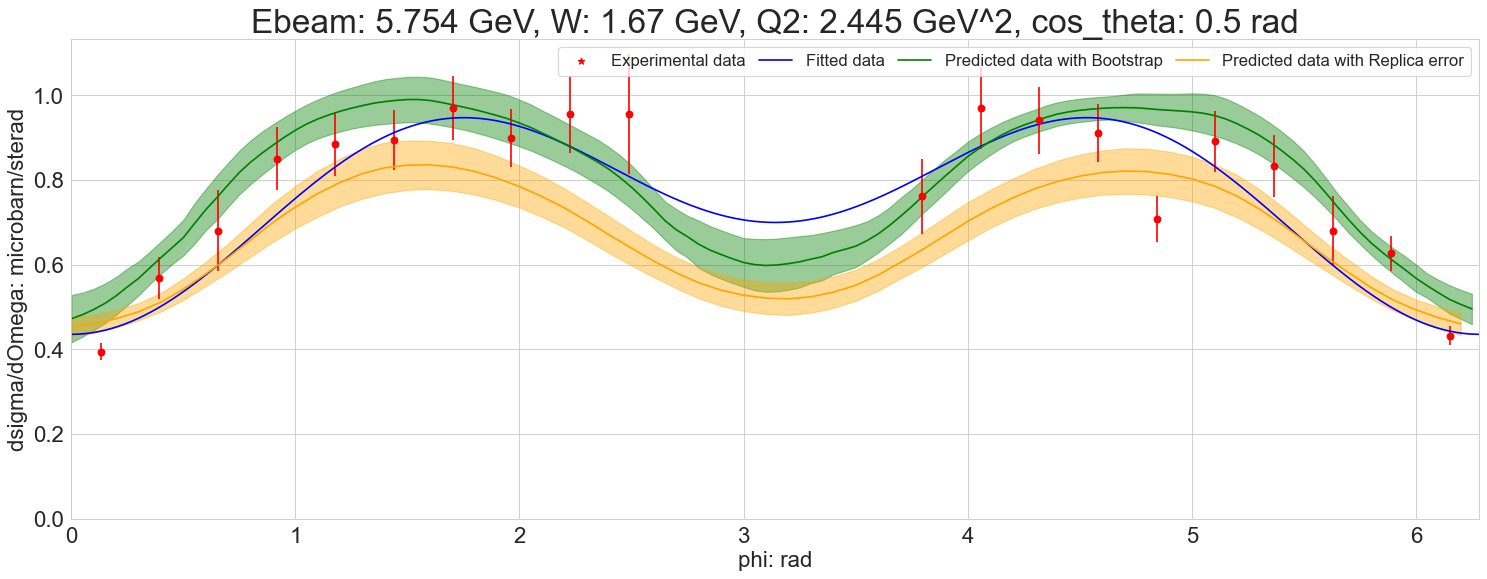

In [110]:
def plot_joint_cross_sections_replica_vs_bootstrap(df=df_exp, E_beam=E, W=W, Q2=Q2, cos_theta=cos_theta, 
                                                   df_grid=df_bootstrap, df_replica=df_preds):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)
    
    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.W == W_df)&
                        (df.Q2 == Q2_df)&
                        (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')
 
            
    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error
    
    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted
    ydata_preds_std = df_grid_instance_set.dsigma_dOmega_predicted_std
    
    xdata_preds_replica = df_replica.phi
    ydata_preds_replica = df_replica.preds_mean
    ydata_preds_std_replica = df_replica.preds_std


    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]


    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]
    
    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})
    
    plt.figure(figsize=(22, 6), dpi=80)
    # plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')
    
    
    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             # label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data with Bootstrap'
             # label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )
    plt.fill_between(xdata_preds, ydata_preds-ydata_preds_std, ydata_preds+ydata_preds_std, color='green', alpha=0.4)
    
    plt.plot(xdata_preds_replica,
             ydata_preds_replica,
             color='orange',
             label=f'Predicted data with Replica error'
             # label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )
    plt.fill_between(xdata_preds_replica, 
                     ydata_preds_replica-ydata_preds_std_replica, 
                     ydata_preds_replica+ydata_preds_std_replica, color='orange', alpha=0.4)


    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma/dOmega: microbarn/sterad", fontsize="20")

    plt.tick_params(axis='both', which='major', labelsize=20)

    plt.title(f"Ebeam: {E_beam} GeV, W: {W} GeV, Q2: {Q2} GeV^2, cos_theta: {cos_theta} rad", fontsize="30")
    plt.legend(loc ="upper right", fontsize="15",  ncol=4, columnspacing=0.8)
    # plt.savefig(f'./final_checks_bootstrap_3.0/3_models/cross_sections/E_beam={E_beam}/Q2={Q2}/W={W}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.subplots_adjust(left=0.1, right=0.9, top=1.1, bottom=0.1)
    plt.show()
    plt.close()
    return None
plot_joint_cross_sections_replica_vs_bootstrap()

# Replicas vs replica generator (to check data in between)

In [10]:
df = pd.read_csv('./data/replicas_new/df_replicas_final.csv')
df

,Unnamed: 0,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,weight,cos_phi,...,dsigma_dOmega_replica_prediction_92,dsigma_dOmega_replica_prediction_93,dsigma_dOmega_replica_prediction_94,dsigma_dOmega_replica_prediction_95,dsigma_dOmega_replica_prediction_96,dsigma_dOmega_replica_prediction_97,dsigma_dOmega_replica_prediction_98,dsigma_dOmega_replica_prediction_99,replicas_mean,replicas_std
0,0,5.754,1.11,1.715,-0.1,0.130900,0.24835,0.081150,12.322859,0.991445,...,0.198167,0.196467,0.243768,0.222099,0.260259,0.216111,0.205670,0.210074,0.229316,0.077667
1,1,5.754,1.11,1.715,-0.1,0.392699,0.31508,0.089290,11.199462,0.923880,...,0.248041,0.227518,0.267380,0.225885,0.276039,0.236201,0.203737,0.224275,0.264233,0.086747
2,2,5.754,1.11,1.715,-0.1,0.654498,0.33037,0.097020,10.307153,0.793353,...,0.268417,0.272157,0.307784,0.251945,0.321410,0.276929,0.231673,0.262078,0.271251,0.110693
3,3,5.754,1.11,1.715,-0.1,0.916298,0.22582,0.059600,16.778523,0.608761,...,0.308040,0.334550,0.436992,0.455408,0.363735,0.338374,0.254481,0.329250,0.312641,0.053489
4,4,5.754,1.11,1.715,0.1,0.130900,0.31506,0.095400,10.482180,0.991445,...,0.226692,0.217397,0.252706,0.245914,0.284179,0.231403,0.247193,0.230651,0.232371,0.095654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41294,41294,5.754,1.15,4.155,0.9,3.403392,0.24095,0.071110,14.062691,-0.965926,...,0.098802,0.080847,0.089232,0.054938,0.072563,0.103285,0.096035,0.089691,0.084543,0.060768
41295,41295,5.754,1.15,4.155,0.9,3.926991,0.19967,0.078718,12.703601,-0.707107,...,0.096430,0.082610,0.120873,0.071381,0.091333,0.101891,0.116943,0.094229,0.091402,0.078685
41296,41296,5.754,1.15,4.155,0.9,4.450590,0.10080,0.037233,26.857784,-0.258819,...,0.107660,0.084204,0.134062,0.092278,0.098791,0.096181,0.123181,0.095655,0.088151,0.040197
41297,41297,5.754,1.15,4.155,0.9,4.974188,0.13921,0.065774,15.203686,0.258819,...,0.102161,0.091751,0.107931,0.107508,0.095655,0.086461,0.127393,0.089616,0.085788,0.059134


In [19]:
# extract models path
basic_path = './wandb_local_logs/MSU_interpol_unified_notebooks_replication_1'
models = next(os.walk(basic_path))
models_we_need = []
for model in models[1]:
    if int(model.split('-')[-1]) >= 10:
        models_we_need.append(model)
        
models_path = []
for i, model in enumerate(models_we_need):
    model_name = next(os.walk(os.path.join(basic_path, models_we_need[i], 'checkpoints')))[-1][0]
    model_path = os.path.join(basic_path, models_we_need[i], 'checkpoints', model_name)
    models_path.append(model_path)
    
len(models_path)

100

In [29]:
# generate grid
if True:
    Ebeam = hyperparams_dict.get('energy')
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
             for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                    for phi in np.arange(0, 2*np.pi, step_phi):
                        data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: np.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: np.sin(x))
    df_grid['theta'] = np.arccos(df_grid['cos_theta'])
    df_grid['sin_theta'] = np.sin(df_grid.theta)

100%|██████████| 177/177 [00:04<00:00, 35.41it/s]


In [95]:
E = 5.754
W = 1.23
Q2 = 2.915
cos_theta = -0.7

df_preds = df_grid[(df_grid.Ebeam == E)&
              (df_grid.W == W)&
              (df_grid.Q2 == Q2)&
              (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

df_exp = df[(df.Ebeam == E)&
            (df.W == W)&
            (df.Q2 == Q2)&
            (np.round(df.cos_theta, 1) == cos_theta)].sort_values('phi')

print(df_preds.shape, df_exp.shape)

(126, 9) (16, 216)


In [96]:
i = 0
for i in range(len(models_path)):
    model = InterpolRegressor.load_from_checkpoint(models_path[i], hyperparams=hyperparams_dict)
    model.eval()
    to_predict = df_preds[['Ebeam', 'W', 'Q2', 'theta', 'cos_theta', 'sin_theta', 'phi', 'cos_phi', 'sin_phi']]
    dsigma_dOmega_predicted = model.to('cpu').forward(
                torch.tensor(to_predict.to_numpy(), dtype=torch.float32)).detach()
    df_preds[f'preds_{i}'] = dsigma_dOmega_predicted

df_preds['preds_mean'] = df_preds.apply(lambda x: np.mean(x[[f'preds_{i}' for i in range(100)]]), axis=1)
df_preds['preds_std'] = df_preds.apply(lambda x: np.std(x[[f'preds_{i}' for i in range(100)]]), axis=1)

2025-02-09 23:44:18,526 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/expert-snowball-42/checkpoints/exp_name=0val_loss=0.11589-epoch=98.ckpt
2025-02-09 23:44:18,646 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/dark-capybara-99/checkpoints/exp_name=0val_loss=0.12714-epoch=59.ckpt
2025-02-09 23:44:18,757 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/serene-oath-94/checkpoints/exp_name=0val_loss=0.10981-epoch=84.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:18,860 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/absurd-shape-60/checkpoints/exp_name=0val_loss=0.13298-epoch=53.ckpt
2025-02-09 23:44:18,961 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/earthy-morning-87/checkpoints/exp_name=0val_loss=0.12822-epoch=62.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:19,069 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/unique-silence-108/checkpoints/exp_name=0val_loss=0.11653-epoch=47.ckpt
2025-02-09 23:44:19,168 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/elated-grass-67/checkpoints/exp_name=0val_loss=0.12266-epoch=30.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:19,268 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/smooth-disco-79/checkpoints/exp_name=0val_loss=0.15023-epoch=86.ckpt
2025-02-09 23:44:19,367 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/dulcet-shape-35/checkpoints/exp_name=0val_loss=0.13002-epoch=48.ckpt
2025-02-09 23:44:19,468 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/sandy-spaceship-58/checkpoints/exp_name=0val_loss=0.13338-epoch=76.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:19,583 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/dry-blaze-43/checkpoints/exp_name=0val_loss=0.12180-epoch=79.ckpt
2025-02-09 23:44:19,686 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/avid-breeze-101/checkpoints/exp_name=0val_loss=0.12655-epoch=25.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:19,787 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/zany-paper-41/checkpoints/exp_name=0val_loss=0.12502-epoch=21.ckpt
2025-02-09 23:44:19,893 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/brisk-valley-30/checkpoints/exp_name=0val_loss=0.11591-epoch=83.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:19,999 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/radiant-shape-64/checkpoints/exp_name=0val_loss=0.11942-epoch=82.ckpt
2025-02-09 23:44:20,103 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/smart-totem-76/checkpoints/exp_name=0val_loss=0.11997-epoch=59.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:20,209 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/driven-energy-91/checkpoints/exp_name=0val_loss=0.12871-epoch=47.ckpt
2025-02-09 23:44:20,312 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/distinctive-dew-86/checkpoints/exp_name=0val_loss=0.11374-epoch=43.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:20,415 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/ancient-armadillo-46/checkpoints/exp_name=0val_loss=0.12887-epoch=70.ckpt
2025-02-09 23:44:20,518 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/restful-haze-71/checkpoints/exp_name=0val_loss=0.11701-epoch=58.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:20,621 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/revived-firebrand-81/checkpoints/exp_name=0val_loss=0.16173-epoch=31.ckpt
2025-02-09 23:44:20,730 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/desert-paper-73/checkpoints/exp_name=0val_loss=0.11104-epoch=61.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:20,837 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/astral-waterfall-53/checkpoints/exp_name=0val_loss=0.13244-epoch=46.ckpt
2025-02-09 23:44:20,937 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/swept-plant-104/checkpoints/exp_name=0val_loss=0.12855-epoch=31.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:21,038 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/zesty-violet-98/checkpoints/exp_name=0val_loss=0.12575-epoch=39.ckpt
2025-02-09 23:44:21,142 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/helpful-resonance-100/checkpoints/exp_name=0val_loss=0.13068-epoch=39.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:21,246 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/swept-fire-54/checkpoints/exp_name=0val_loss=0.12227-epoch=57.ckpt
2025-02-09 23:44:21,346 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/curious-pine-75/checkpoints/exp_name=0val_loss=0.11667-epoch=57.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:21,445 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/devout-blaze-36/checkpoints/exp_name=0val_loss=0.14395-epoch=36.ckpt
2025-02-09 23:44:21,543 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/super-elevator-109/checkpoints/exp_name=0val_loss=0.12319-epoch=59.ckpt
2025-02-09 23:44:21,643 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/fancy-spaceship-93/checkpoints/exp_name=0val_loss=0.12751-epoch=48.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:21,742 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/deep-firebrand-19/checkpoints/exp_name=0val_loss=0.13798-epoch=38.ckpt
2025-02-09 23:44:21,843 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/jumping-universe-18/checkpoints/exp_name=0val_loss=0.10525-epoch=67.ckpt
2025-02-09 23:44:21,941 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/brisk-tree-38/checkpoints/exp_name=0val_loss=0.13092-epoch=43.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:22,039 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/absurd-wood-13/checkpoints/exp_name=0val_loss=0.11621-epoch=87.ckpt
2025-02-09 23:44:22,139 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/devout-night-107/checkpoints/exp_name=0val_loss=0.12170-epoch=53.ckpt
2025-02-09 23:44:22,237 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/balmy-wood-70/checkpoints/exp_name=0val_loss=0.13985-epoch=55.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:22,341 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/dashing-haze-33/checkpoints/exp_name=0val_loss=0.13316-epoch=42.ckpt
2025-02-09 23:44:22,439 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/radiant-bush-14/checkpoints/exp_name=0val_loss=0.13713-epoch=42.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:22,536 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/summer-yogurt-77/checkpoints/exp_name=0val_loss=0.13066-epoch=56.ckpt
2025-02-09 23:44:22,639 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/wandering-armadillo-27/checkpoints/exp_name=0val_loss=0.12792-epoch=46.ckpt
2025-02-09 23:44:22,743 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/comfy-voice-31/checkpoints/exp_name=0val_loss=0.11398-epoch=95.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:22,844 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/genial-paper-52/checkpoints/exp_name=0val_loss=0.15314-epoch=26.ckpt
2025-02-09 23:44:22,945 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/avid-surf-97/checkpoints/exp_name=0val_loss=0.14853-epoch=25.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:23,045 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/feasible-flower-88/checkpoints/exp_name=0val_loss=0.12949-epoch=101.ckpt
2025-02-09 23:44:23,140 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/swift-gorge-57/checkpoints/exp_name=0val_loss=0.12075-epoch=66.ckpt
2025-02-09 23:44:23,238 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/sleek-water-102/checkpoints/exp_name=0val_loss=0.14080-epoch=62.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:23,334 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/legendary-deluge-10/checkpoints/exp_name=0val_loss=0.12444-epoch=65.ckpt
2025-02-09 23:44:23,434 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/toasty-morning-12/checkpoints/exp_name=0val_loss=0.12487-epoch=43.ckpt
2025-02-09 23:44:23,528 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/desert-pine-50/checkpoints/exp_name=0val_loss=0.12567-epoch=46.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:23,627 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/smooth-pyramid-44/checkpoints/exp_name=0val_loss=0.11967-epoch=67.ckpt
2025-02-09 23:44:23,724 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/dutiful-serenity-37/checkpoints/exp_name=0val_loss=0.14322-epoch=72.ckpt
2025-02-09 23:44:23,821 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/noble-glitter-82/checkpoints/exp_name=0val_loss=0.12824-epoch=51.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:23,918 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/blooming-silence-21/checkpoints/exp_name=0val_loss=0.14201-epoch=61.ckpt
2025-02-09 23:44:24,016 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/chocolate-resonance-51/checkpoints/exp_name=0val_loss=0.12998-epoch=46.ckpt
2025-02-09 23:44:24,115 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/silver-violet-22/checkpoints/exp_name=0val_loss=0.16487-epoch=33.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:24,213 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/upbeat-morning-47/checkpoints/exp_name=0val_loss=0.12042-epoch=60.ckpt
2025-02-09 23:44:24,313 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/winter-dawn-55/checkpoints/exp_name=0val_loss=0.11567-epoch=69.ckpt
2025-02-09 23:44:24,409 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/unique-haze-25/checkpoints/exp_name=0val_loss=0.13601-epoch=65.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:24,507 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/gentle-dream-83/checkpoints/exp_name=0val_loss=0.13981-epoch=50.ckpt
2025-02-09 23:44:24,602 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/usual-music-84/checkpoints/exp_name=0val_loss=0.12068-epoch=49.ckpt
2025-02-09 23:44:24,701 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/driven-sponge-89/checkpoints/exp_name=0val_loss=0.13450-epoch=40.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:24,798 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/wobbly-sun-39/checkpoints/exp_name=0val_loss=0.11907-epoch=61.ckpt
2025-02-09 23:44:24,896 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/sweet-deluge-28/checkpoints/exp_name=0val_loss=0.11994-epoch=72.ckpt
2025-02-09 23:44:24,991 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/hearty-pyramid-49/checkpoints/exp_name=0val_loss=0.14786-epoch=54.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:25,088 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/neat-pyramid-24/checkpoints/exp_name=0val_loss=0.15722-epoch=52.ckpt
2025-02-09 23:44:25,184 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/sandy-eon-59/checkpoints/exp_name=0val_loss=0.16537-epoch=35.ckpt
2025-02-09 23:44:25,278 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/sunny-monkey-105/checkpoints/exp_name=0val_loss=0.14517-epoch=74.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:25,375 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/noble-jazz-69/checkpoints/exp_name=0val_loss=0.14909-epoch=62.ckpt
2025-02-09 23:44:25,472 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/pretty-gorge-72/checkpoints/exp_name=0val_loss=0.14045-epoch=32.ckpt
2025-02-09 23:44:25,569 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/lively-wildflower-34/checkpoints/exp_name=0val_loss=0.14689-epoch=30.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:25,663 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/robust-butterfly-61/checkpoints/exp_name=0val_loss=0.15639-epoch=42.ckpt
2025-02-09 23:44:25,759 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/iconic-leaf-23/checkpoints/exp_name=0val_loss=0.12484-epoch=50.ckpt
2025-02-09 23:44:25,856 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/comic-feather-26/checkpoints/exp_name=0val_loss=0.12573-epoch=51.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:25,954 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/summer-capybara-103/checkpoints/exp_name=0val_loss=0.14590-epoch=54.ckpt
2025-02-09 23:44:26,050 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/fiery-pine-11/checkpoints/exp_name=0val_loss=0.12653-epoch=52.ckpt
2025-02-09 23:44:26,147 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/denim-glade-15/checkpoints/exp_name=0val_loss=0.12158-epoch=44.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:26,244 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/cool-river-45/checkpoints/exp_name=0val_loss=0.11675-epoch=69.ckpt
2025-02-09 23:44:26,343 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/easy-flower-85/checkpoints/exp_name=0val_loss=0.12277-epoch=46.ckpt
2025-02-09 23:44:26,440 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/solar-lake-63/checkpoints/exp_name=0val_loss=0.13176-epoch=63.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:26,536 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/quiet-blaze-65/checkpoints/exp_name=0val_loss=0.15363-epoch=36.ckpt
2025-02-09 23:44:26,634 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/rich-cherry-95/checkpoints/exp_name=0val_loss=0.12574-epoch=83.ckpt
2025-02-09 23:44:26,729 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/fresh-river-74/checkpoints/exp_name=0val_loss=0.12042-epoch=62.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:26,824 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/smooth-sky-78/checkpoints/exp_name=0val_loss=0.12060-epoch=50.ckpt
2025-02-09 23:44:26,927 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/neat-silence-62/checkpoints/exp_name=0val_loss=0.13049-epoch=24.ckpt
2025-02-09 23:44:27,046 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/amber-armadillo-90/checkpoints/exp_name=0val_loss=0.12585-epoch=75.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:27,164 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/classic-bee-48/checkpoints/exp_name=0val_loss=0.13078-epoch=75.ckpt
2025-02-09 23:44:27,279 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/volcanic-wave-20/checkpoints/exp_name=0val_loss=0.11596-epoch=61.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:27,451 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/radiant-smoke-68/checkpoints/exp_name=0val_loss=0.12666-epoch=75.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


2025-02-09 23:44:27,600 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/silver-river-66/checkpoints/exp_name=0val_loss=0.12722-epoch=29.ckpt
2025-02-09 23:44:27,704 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/avid-terrain-29/checkpoints/exp_name=0val_loss=0.13607-epoch=32.ckpt
2025-02-09 23:44:27,799 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/dark-salad-56/checkpoints/exp_name=0val_loss=0.13479-epoch=42.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:27,898 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/ethereal-universe-32/checkpoints/exp_name=0val_loss=0.11905-epoch=104.ckpt
2025-02-09 23:44:27,996 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/efficient-feather-80/checkpoints/exp_name=0val_loss=0.13746-epoch=30.ckpt
2025-02-09 23:44:28,099 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/drawn-cloud-92/checkpoints/exp_name=0val_loss=0.14394-epoch=34.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:28,195 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/avid-bush-16/checkpoints/exp_name=0val_loss=0.11167-epoch=91.ckpt
2025-02-09 23:44:28,291 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/drawn-donkey-96/checkpoints/exp_name=0val_loss=0.11433-epoch=64.ckpt
2025-02-09 23:44:28,387 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/deft-dust-17/checkpoints/exp_name=0val_loss=0.10878-epoch=70.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recom

2025-02-09 23:44:28,487 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/avid-universe-106/checkpoints/exp_name=0val_loss=0.13525-epoch=78.ckpt
2025-02-09 23:44:28,586 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/logical-snowball-40/checkpoints/exp_name=0val_loss=0.13922-epoch=48.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/var/folders/tj/2cbzjkv53dj9l4yrll73xw400000gq/T/ipykernel_52695/1091317374.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

In [97]:
model = InterpolRegressor.load_from_checkpoint(f'/Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/misty-silence-1/checkpoints/exp_name=0val_loss=0.08200-epoch=62.ckpt', hyperparams=hyperparams_dict)
model.eval()
to_predict = df_preds[['Ebeam', 'W', 'Q2', 'theta', 'cos_theta', 'sin_theta', 'phi', 'cos_phi', 'sin_phi']]
df_preds['generator_prediction'] = model.to('cpu').forward(torch.tensor(to_predict.to_numpy(),dtype=torch.float32)).detach().reshape(-1).numpy()

2025-02-09 23:44:28,716 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/wandb_local_logs/MSU_interpol_unified_notebooks_replication_1/misty-silence-1/checkpoints/exp_name=0val_loss=0.08200-epoch=62.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/var/folders/tj/2cbzjkv53dj9l4yrll73xw400000gq/T/ipykernel_52695/2366165485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_preds['generator_prediction'] = model.to('cpu').forward(torch.tensor(to_predict.to_numpy(),dtype=torch.float32)).detach().reshape(-1).numpy()


In [98]:
def plot_exp_and_replicas_and_generator(df_exp = df_exp, df_replicas=df_preds):
    #input data
    xdata_exp = df_exp.phi
    ydata_expt = df_exp.dsigma_dOmega
    data_exp_error = df_exp.error
    
    xdata_replicas = df_replicas.phi
    ydata_replicas = df_replicas.preds_mean
    ydata_replicas_std = df_replicas.preds_std
    
    xdata_generator = df_replicas.phi
    ydata_generator = df_replicas.generator_prediction
    
    xdata_generator_replicas_trained = df_exp.phi
    ydata_generator_replicas_trained = df_exp.dsigma_dOmega_predicted_stage_1
    data_generator_replicas_trained_error = df_exp.error
    
    
    plt.figure(figsize=(22, 6), dpi=80)
    plt.scatter(x=xdata_exp,
                y=ydata_expt,
                color='red', marker='*', label=f"Experimental data")
    plt.errorbar(x=xdata_exp,
                 y=ydata_expt,
                 yerr=data_exp_error,
                 color='red',
                 fmt='o')

    # plt.plot(xdata_replicas,
    #          ydata_replicas,
    #          color='green',
    #          label=f'Replicas predictions'
    #          # label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
    #          )
    plt.fill_between(xdata_replicas, ydata_replicas-ydata_replicas_std, 
                     ydata_replicas+ydata_replicas_std, color='green', alpha=0.4, label=f"Replicas prediction")
    
    plt.plot(xdata_generator,
             ydata_generator,
             color='purple',
             label=f'Replicas generator prediction'
             # label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )
    
    plt.scatter(xdata_generator_replicas_trained,
             ydata_generator_replicas_trained,
             color='purple',
             label=f'Replicas generator data'
             # label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )
    plt.errorbar(x=xdata_generator_replicas_trained,
                 y=ydata_generator_replicas_trained,
                 yerr=data_generator_replicas_trained_error,
                 color='purple',
                 fmt='o')


    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma/dOmega: microbarn/sterad", fontsize="20")

    plt.tick_params(axis='both', which='major', labelsize=20)

    plt.title(f"Ebeam: {Ebeam} GeV, W: {W} GeV, Q2: {Q2} GeV^2, cos_theta: {cos_theta} rad", fontsize="30")
    plt.legend(loc ="upper right", fontsize="15",  ncol=4, columnspacing=0.8)
    # plt.savefig(f'./final_checks_bootstrap_3.0/3_models/cross_sections/E_beam={E_beam}/Q2={Q2}/W={W}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.subplots_adjust(left=0.1, right=0.9, top=1.1, bottom=0.1)
    plt.show()
    plt.close()
    return None

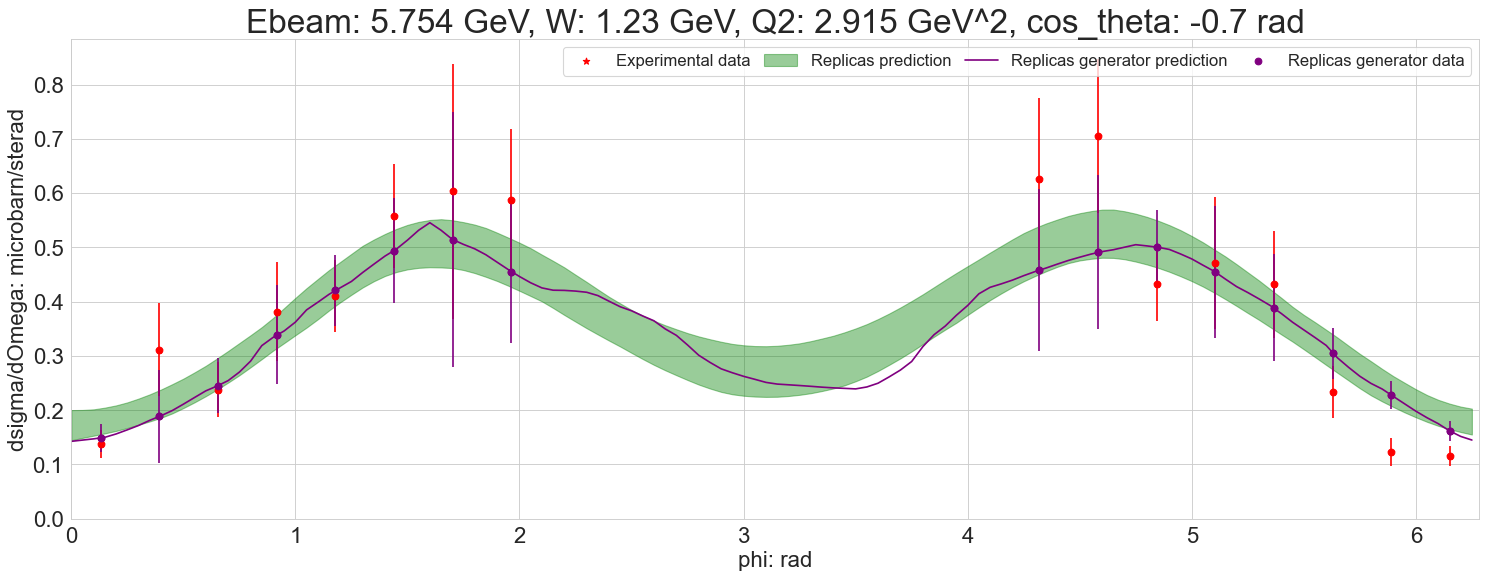

In [99]:
plot_exp_and_replicas_and_generator()